## Mini Project 02

In [1]:
import pandas as pd
import numpy as np
import datetime
import dateutil
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import DateOffset
from dateutil.relativedelta import relativedelta
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [2]:
!pip install openpyxl

# Calculating Spot Rates from Par Yields from US DoT website

In [83]:
daily_rates = pd.read_csv('daily-treasury-rates.csv',index_col=0)
par_yields = daily_rates[daily_rates.index=='02/24/2025'].values[0]/100 # decimals

maturities = np.array([
    1/12, 1.5/12, 2/12, 3/12, 4/12, 6/12,
    1, 2, 3, 5, 7, 10, 20, 30
])

def bootstrap_spot_curve(par_yields, maturities, freq=2):
    spot_rates = []
    for i, (y, T) in enumerate(zip(par_yields, maturities)):
        if T <= 1:  
            spot_rates.append(y)
        else:
            n_periods = int(T * freq)
            cpn = y / freq * 100  
            price = 100.0

            pv_coupons = 0
            for j in range(1, n_periods):
                t = j / freq
                s_prev = np.interp(t, maturities[:len(spot_rates)], spot_rates)
                pv_coupons += cpn / (1 + s_prev/freq)**(j)

            cashflow = cpn + 100
            s = ((cashflow / (price - pv_coupons))**(1/n_periods) - 1) * freq
            spot_rates.append(s)
    return np.array(spot_rates)

spot_curve = bootstrap_spot_curve(par_yields, maturities)

df = pd.DataFrame({
    "Maturity (Y)": maturities,
    "Par Yield (%)": par_yields*100,
    "Spot Rate (%)": spot_curve*100
})

print(df.round(3))


    Maturity (Y)  Par Yield (%)  Spot Rate (%)
0          0.083           4.36          4.360
1          0.125           4.38          4.380
2          0.167           4.37          4.370
3          0.250           4.31          4.310
4          0.333           4.34          4.340
5          0.500           4.30          4.300
6          1.000           4.15          4.150
7          2.000           4.13          4.129
8          3.000           4.17          4.171
9          5.000           4.23          4.237
10         7.000           4.32          4.337
11        10.000           4.40          4.429
12        20.000           4.69          4.888
13        30.000           4.66          4.636


# Clean Bonds Data

1. Calculating Price as average of Ask/Bid price
2. Calculating Remaining years of maturity
3. Dropping treasuries maturing in odd months - maturing not in February, May, August, November. 
4. Adjusting dates with maturities with last date of Feb, May, Aug, Nov - to middle of the month date - just to correct for convention
5. Calculating accrued interest to adjust the dirty price (still not sure if the price listed is clean/dirty)

In [3]:
def adjust_to_mid_month(date):
    if date == (date + MonthEnd(0)):
        return date.replace(day=15)
    else:
        return date

In [4]:
def clean_bonds_data(path, valuation_date, standard_maturity):

    bonds = pd.read_excel(path)
    bonds = bonds.drop(columns=['Issuer Name'])
    bonds['Issue Date']= pd.to_datetime(bonds['Issue Date'])
    bonds['Maturity'] = pd.to_datetime(bonds['Maturity'])
    #average price
    bonds['Mid Price'] = (bonds['Bid Price'] + bonds['Ask Price'])/2
    bonds['Valuation'] = valuation_date
    bonds['Valuation'] = pd.to_datetime(bonds['Valuation'])
    #remaining maturity
    bonds['Remaining'] = bonds['Maturity']-bonds['Valuation']
    bonds['Remaining'] = bonds['Remaining'].dt.days/365
    #actual maturity (or full tenure of the bond)
    bonds['Actual'] = bonds['Maturity']-bonds['Issue Date']
    bonds['Actual'] = bonds['Actual'].dt.days/365
    bonds['FV'] = 100
    bonds['Maturity Month'] = bonds['Maturity'].dt.month
    if standard_maturity == True:
        arrbonds = [2,5,8,11]
        bondspure = bonds[bonds['Maturity Month'].isin(arrbonds)==True]
    else:
        bondspure = bonds
    bondspure['Maturity Date'] = bondspure['Maturity'].dt.day
    #adjusting maturity dates
    bondspure['Maturity_Adjusted'] = bondspure['Maturity'].apply(adjust_to_mid_month)
    #calculating coupon
    bondspure['Coupon'] = bondspure['Cpn']/100*bonds['FV']
    bondspure['Coupon'] = bondspure['Coupon']/2
    #dropping bonds that have already matured given the valuation date - i.e. not active bonds
    bondspure = bondspure[bondspure['Maturity_Adjusted']>bondspure['Valuation']]
    return bondspure

In [5]:
path = 'bondsdata.xlsx'
valuation_date = datetime.date(2025,2,24)
bondspure = clean_bonds_data(path, valuation_date, standard_maturity = True)
bonds = clean_bonds_data(path, valuation_date, standard_maturity = False)

/var/folders/dz/50cxkjr943dgncn0g_w642kr0000gn/T/ipykernel_5265/1310562519.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bondspure['Maturity Date'] = bondspure['Maturity'].dt.day
/var/folders/dz/50cxkjr943dgncn0g_w642kr0000gn/T/ipykernel_5265/1310562519.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bondspure['Maturity_Adjusted'] = bondspure['Maturity'].apply(adjust_to_mid_month)
/var/folders/dz/50cxkjr943dgncn0g_w642kr0000gn/T/ipykernel_5265/1310562519.py:28: SettingWithCopyWarning: 
A value i

# Calculating Accrued Interest from last coupon

In [6]:
def get_last_coupon_date(maturity_date, valuation_date):
    coupon_date = maturity_date
    while coupon_date > valuation_date:
        coupon_date -= relativedelta(months=6)
    return coupon_date

In [7]:
def accrued_interest(bondspure):
    bondspure['Last_Coupon_Date'] = bondspure.apply(
    lambda row: get_last_coupon_date(row['Maturity_Adjusted'], row['Valuation']),
    axis=1
    )
    #calculating the accrued interest as "(Held Period/Total period)*Coupon"
    bondspure['Next_Last_Coupon_Date'] = bondspure['Last_Coupon_Date'] + DateOffset(months=6)
    bondspure['Total Period Days'] = bondspure['Next_Last_Coupon_Date']-bondspure['Last_Coupon_Date']
    bondspure['Total Period Days'] = bondspure['Total Period Days'].dt.days
    bondspure['Held Period Days'] = bondspure['Valuation']-bondspure['Last_Coupon_Date']
    bondspure['Held Period Days'] = bondspure['Held Period Days'].dt.days
    bondspure['Accrued Interest'] = bondspure['Held Period Days']/bondspure['Total Period Days']
    bondspure['Accrued Interest'] = bondspure['Accrued Interest']*bondspure['Coupon']
    bondspure['Clean Price']  = bondspure['Mid Price']-bondspure['Accrued Interest']
    return bondspure

In [8]:
bondspure = accrued_interest(bondspure)
bonds = accrued_interest(bonds)

In [11]:
bondsclean = bondspure[['Issue Date','Maturity_Adjusted','Valuation','Mid Price','Clean Price','FV',
                        'Actual','Remaining','Cpn','Coupon']]
bondscleanall = bonds[['Issue Date','Maturity_Adjusted','Valuation','Mid Price','Clean Price','FV',
                        'Actual','Remaining','Cpn','Coupon']]

# Calculating cashflow and cashflow times schedules

In [12]:
def get_cashflows(coupon_rate, maturity_date, valuation_date, face_value=100):
    coupon_payment = (coupon_rate / 100 / 2) * face_value
    coupon_date = maturity_date
    coupon_dates = []
    while coupon_date > valuation_date:
        coupon_dates.append(coupon_date)
        coupon_date -= relativedelta(months=6)
    coupon_dates = coupon_dates[::-1]
    coupon_times = []

    for date in coupon_dates:
        diff = date-valuation_date
        days = diff.days
        coupon_times.append(days/365)

    cf = []
    for dt in coupon_dates[:-1]:
        cf.append(coupon_payment)

    cf.append(coupon_payment + face_value)
    
    return cf


In [13]:
def get_times(maturity_date, valuation_date):

    coupon_date = maturity_date
    coupon_dates = []

    while coupon_date > valuation_date:
        coupon_dates.append(coupon_date)
        coupon_date -= relativedelta(months=6)

    coupon_dates = coupon_dates[::-1]
    coupon_times = []

    for date in coupon_dates:
        diff = date-valuation_date
        days = diff.days
        coupon_times.append(days/365)

    return coupon_times

In [14]:
bondsclean['CF_Schedule'] = bondsclean.apply(
    lambda row: get_cashflows(row['Cpn'],row['Maturity_Adjusted'], row['Valuation'],row['FV']),
    axis=1
)
bondscleanall['CF_Schedule'] = bondscleanall.apply(
    lambda row: get_cashflows(row['Cpn'],row['Maturity_Adjusted'], row['Valuation'],row['FV']),
    axis=1
)

/var/folders/dz/50cxkjr943dgncn0g_w642kr0000gn/T/ipykernel_5265/1333479975.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bondsclean['CF_Schedule'] = bondsclean.apply(
/var/folders/dz/50cxkjr943dgncn0g_w642kr0000gn/T/ipykernel_5265/1333479975.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bondscleanall['CF_Schedule'] = bondscleanall.apply(


In [15]:
bondsclean['CF_times'] = bondsclean.apply(
    lambda row: get_times(row['Maturity_Adjusted'], row['Valuation']),
    axis=1
)
bondscleanall['CF_times'] = bondscleanall.apply(
    lambda row: get_times(row['Maturity_Adjusted'], row['Valuation']),
    axis=1
)

/var/folders/dz/50cxkjr943dgncn0g_w642kr0000gn/T/ipykernel_5265/2660143481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bondsclean['CF_times'] = bondsclean.apply(
/var/folders/dz/50cxkjr943dgncn0g_w642kr0000gn/T/ipykernel_5265/2660143481.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bondscleanall['CF_times'] = bondscleanall.apply(


In [16]:
#filtering out super low maturity bonds

bondsfilter1 = bondsclean[bondsclean['Remaining']>0.5]
bondsfilter2 = bondscleanall[bondscleanall['Remaining']>0.5]

# Nelson Siegel Bootstrapping

1. Using all cashflows/all maturities to optimize parameters in the nelson siegel equation. 
2. Choosing to bound long-term level (beta0) at 0 (assuming it is not negative) and 4.5% for a long term level assumption
3. Slope/Curvature bounds are a broader range
4. Decay is capped at 1.5
5. Using scipy's minimize to bring squared error of actual price and model price

In [19]:
all_cashflows = bondsfilter1['CF_Schedule'].tolist()
all_times = bondsfilter1['CF_times'].tolist()
actual_prices = bondsfilter1['Mid Price'].tolist() #still unsure which of the prices is "clean"

In [20]:
all_cashflows1 = bondsfilter2['CF_Schedule'].tolist()
all_times1 = bondsfilter2['CF_times'].tolist()
actual_prices1 = bondsfilter2['Mid Price'].tolist() #still unsure which of the prices is "clean"

In [22]:
def nelson_siegel(t, beta0, beta1, beta2, lambd):
    t = np.array(t)
    term1 = (1 - np.exp(-lambd * t)) / (lambd * t)
    term2 = term1 - np.exp(-lambd * t)
    return beta0 + beta1 * term1 + beta2 * term2

def discount_factor(t, beta0, beta1, beta2, lambd):
    r = nelson_siegel(t, beta0, beta1, beta2, lambd)
    return np.exp(-r * t)

def objective(params, all_cashflows, all_times, actual_prices):
    beta0, beta1, beta2, lambd = params
    total_error = 0
    for cfs, ts, actual_price in zip(all_cashflows, all_times, actual_prices):
        model_price = price_bond(cfs, ts, beta0, beta1, beta2, lambd)
        total_error += (actual_price - model_price) ** 2
    return total_error

def price_bond(cashflows, times, beta0, beta1, beta2, lambd):
    dfs = discount_factor(times, beta0, beta1, beta2, lambd)
    return np.sum(cashflows * dfs)

In [23]:
initial_guess = [0.04, -0.02, 0.01, 1.0]
bounds = [(0.0,0.07), (-0.2,0.2), (-0.2, 0.2), (0,1)]

result1 = minimize(objective, initial_guess, args=(all_cashflows, all_times, actual_prices), bounds=bounds)
result2 = minimize(objective, initial_guess, args=(all_cashflows1, all_times1, actual_prices1), bounds=bounds)
clean_beta0, clean_beta1, clean_beta2, clean_lambd = result1.x
all_beta0, all_beta1, all_beta2, all_lambd = result2.x

print("Optimized NS parameters (Cleaned data):", result1.x)
print("Optimized NS parameters  (All data):", result2.x)

Optimized NS parameters (Cleaned data): [ 0.05000827  0.00053142 -0.02583512  0.44702402]
Optimized NS parameters  (All data): [ 0.04977744  0.00354378 -0.02743234  0.44833442]


Plotting the yield curve

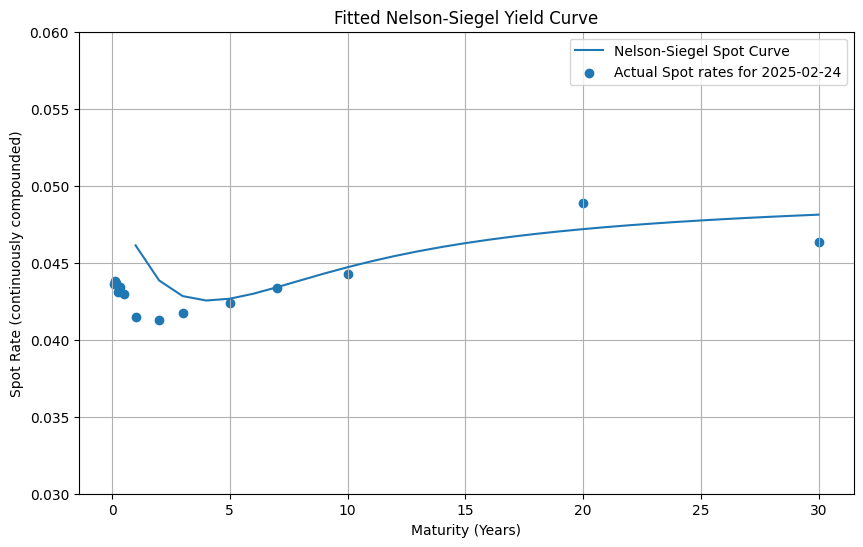

In [ ]:
t_range = np.linspace(1, 30, 30)
clean_yields = nelson_siegel(t_range, clean_beta0, clean_beta1, clean_beta2, clean_lambd)

plt.figure(figsize=(10, 6))
plt.plot(t_range, clean_yields, label='Nelson-Siegel Spot Curve')
plt.scatter(df['Maturity (Y)'],df['Spot Rate (%)']/100, label = 'Actual Spot rates for 2025-02-24')
plt.xlabel("Maturity (Years)")
plt.ylabel("Spot Rate (continuously compounded)")
plt.title("Fitted Nelson-Siegel Yield Curve")
plt.grid(True)
plt.legend()
plt.ylim(0.03,0.06)
plt.show()


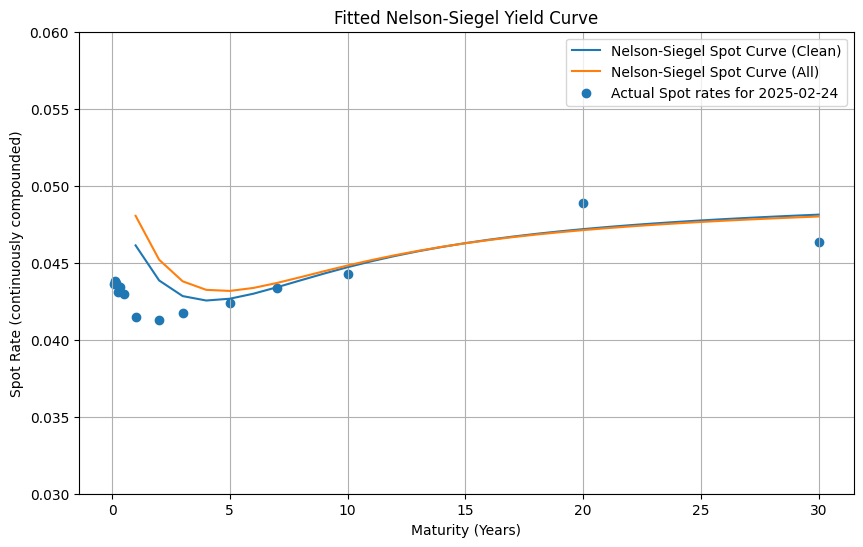

In [84]:
t_range = np.linspace(1, 30, 30)
clean_yields = nelson_siegel(t_range, clean_beta0, clean_beta1, clean_beta2, clean_lambd)
all_yields = nelson_siegel(t_range, all_beta0, all_beta1, all_beta2, all_lambd)
plt.figure(figsize=(10, 6))
plt.plot(t_range, clean_yields, label='Nelson-Siegel Spot Curve (Clean)')
plt.plot(t_range,all_yields, label='Nelson-Siegel Spot Curve (All)')
plt.scatter(df['Maturity (Y)'],df['Spot Rate (%)']/100, label = 'Actual Spot rates for 2025-02-24')
plt.xlabel("Maturity (Years)")
plt.ylabel("Spot Rate (continuously compounded)")
plt.title("Fitted Nelson-Siegel Yield Curve")
plt.grid(True)
plt.legend()
plt.ylim(0.03,0.06)
plt.show()


In [61]:
yields_df = pd.DataFrame()
yields_df.index = t_range
yields_df['Cleaned'] = clean_yields
yields_df['All Bonds'] = all_yields
yields_df['Clean DR'] = np.exp(-clean_yields*t_range)

In [62]:
yields_df

,Cleaned,All Bonds,Clean DR
1.0,0.046126,0.048047,0.954921
2.0,0.043848,0.045194,0.916039
3.0,0.042833,0.043791,0.879415
4.0,0.042546,0.043238,0.843510
5.0,0.042662,0.043169,0.807905
6.0,0.042987,0.043362,0.772655
7.0,0.043406,0.043685,0.737977
8.0,0.043854,0.044061,0.704104
9.0,0.044294,0.044447,0.671230
10.0,0.044708,0.044819,0.639491


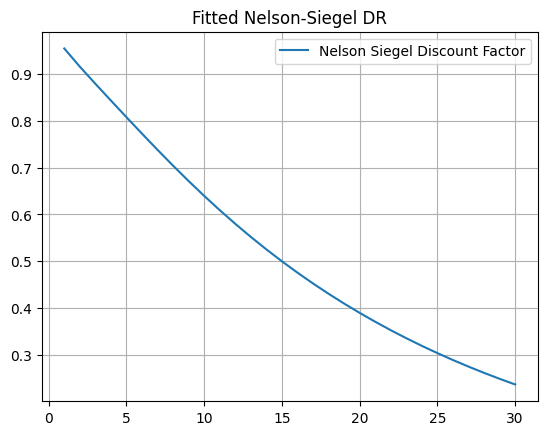

In [200]:
plt.plot(t_range, np.exp(-yields*t_range),label = 'Nelson Siegel Discount Factor')
plt.title("Fitted Nelson-Siegel DR")
plt.grid(True)
plt.legend()


In [32]:
model_actual_df = pd.DataFrame()
model_actual_df['Actual Price'] = actual_prices
model_price = []
for i in range(len(actual_prices)):
    price = price_bond(all_cashflows[i],all_times[i],clean_beta0,clean_beta1,clean_beta2,clean_lambd)
    model_price.append(price)
model_actual_df['Model Price'] = model_price
model_actual_df['Difference'] = model_actual_df['Actual Price'] - model_actual_df['Model Price']
model_actual_df['Difference'] = model_actual_df['Difference']

In [41]:
model_all_df = pd.DataFrame()
model_all_df['Actual Price'] = actual_prices1
model_price_all = []
for i in range(len(actual_prices1)):
    price = price_bond(all_cashflows1[i],all_times1[i],all_beta0,all_beta1,all_beta2,all_lambd)
    model_price_all.append(price)
model_all_df['Model Price'] = model_price_all
model_all_df['Difference'] = model_all_df['Actual Price'] - model_all_df['Model Price']

In [42]:
model_actual_df

,Actual Price,Model Price,Difference
0,99.218750,99.102119,0.116631
1,97.982422,97.880145,0.102277
2,100.333984,100.201896,0.132088
3,100.146484,101.052159,-0.905675
4,98.587891,98.851925,-0.264034
...,...,...,...
196,93.398438,91.969748,1.428689
197,99.460938,99.032429,0.428509
198,93.554688,91.876316,1.678372
199,97.640625,96.946212,0.694413


Text(0.5, 1.0, 'Residuals Actual - Model Clean')

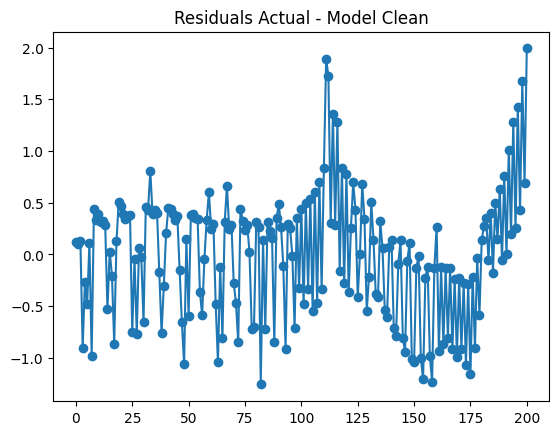

In [87]:
plt.plot(model_actual_df['Difference'],marker='o')
plt.title('Residuals Actual - Model Clean')

Text(0.5, 1.0, 'Residuals Actual - Model All')

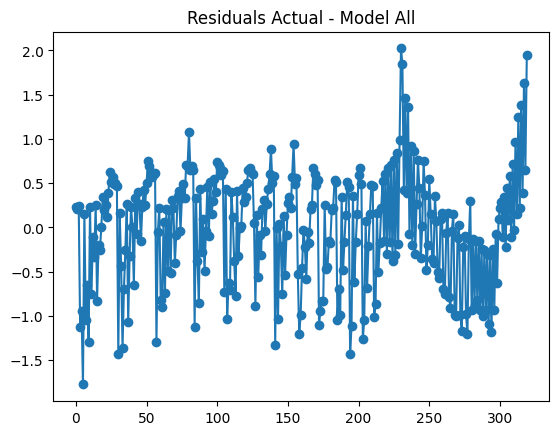

In [88]:
plt.plot(model_all_df['Difference'],marker='o')
plt.title('Residuals Actual - Model All')

In [47]:
rmse_clean = np.sqrt((model_actual_df['Difference']**2).mean())
rmse_all = np.sqrt((model_all_df['Difference']**2).mean())

In [49]:
rmse_clean

np.float64(0.6099926716484075)

In [86]:
!pip install XlsxWriter
with pd.ExcelWriter('final_results.xlsx', engine='xlsxwriter') as writer:
    yields_df.to_excel(writer, sheet_name='Final Estimated Yield Curves', index=True)
    bondspure.to_excel(writer, sheet_name='Calc Bonds Standard Maturities', index=True)
    bonds.to_excel(writer, sheet_name='Calc Bonds with All Maturities', index=True)
    bondsclean.to_excel(writer, sheet_name = 'CF_Times for Clean Bonds',index=True)
    bondsclean.to_excel(writer, sheet_name = 'CF_Times for All Bonds',index=True)
    model_actual_df.to_excel(writer, sheet_name = 'Residuals for Clean Bonds',index=True)
    model_actual_df.to_excel(writer, sheet_name = 'Residuals for All Bonds',index=True)
    df.to_excel(writer, sheet_name='Spot Rates from DoT', index=False)
    daily_rates.to_excel(writer, sheet_name = 'Downloaded Daily US Par rates',index=True)
